In [21]:
%matplotlib inline
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gp
from shapely import wkt, wkb
from shapely.geometry import Point, Polygon, MultiPolygon, LineString, MultiLineString
import contextily as ctx

# helper functions
sys.path.insert(0, 'helper_functions/')

# paths + files
PATH_TO_DATA = '/home/diederik/ams/pyprojects/geospatial_analysis/data/'
AIR_BNB_FILE_MUNGED = 'airbnb_munged.csv' # munged version 
STADSDELEN = 'sd.csv'
BUURT_COMBINATIES = 'buurt_combi.csv'
BUURT = 'buurt.csv'

In [110]:
# load airbnb data from csv
crs_initial = {'init': 'epsg:28992'}
converters = {'geometry': lambda x: wkt.loads(x), 'sd_id': str, 'b_id': str}
# airbnb
df= (pd.read_csv(PATH_TO_DATA + AIR_BNB_FILE_MUNGED, converters=converters, 
                 parse_dates=['last_review']))
df = gp.GeoDataFrame(df, crs=crs_initial, geometry='geometry')
# stadsdelen
sd = pd.read_csv(PATH_TO_DATA + STADSDELEN, converters=converters)
sd = gp.GeoDataFrame(sd, crs=crs_initial, geometry='geometry')
# buurten
buurt = pd.read_csv(PATH_TO_DATA + BUURT, converters=converters)
buurt = gp.GeoDataFrame(buurt, crs=crs_initial, geometry='geometry')

### Where are the most expensive apartments located

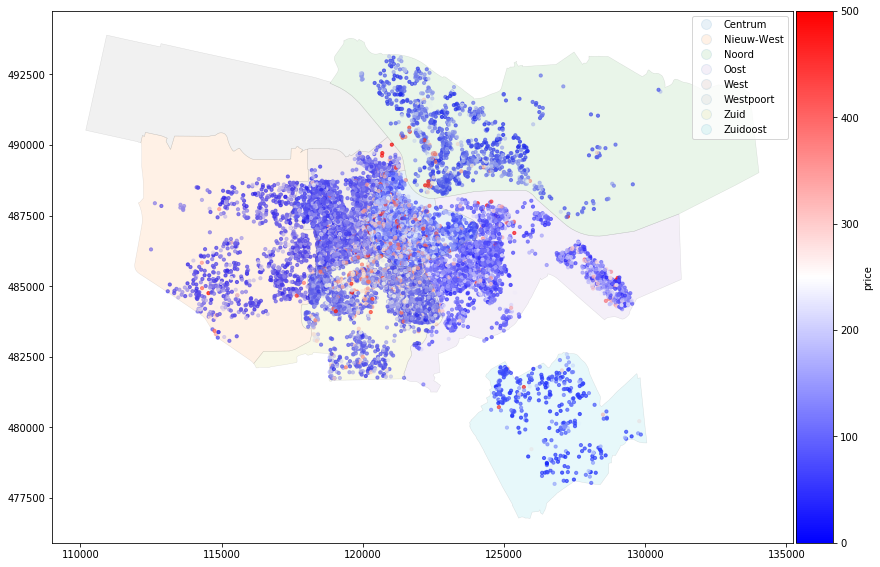

In [93]:
# hell of a job to get the adjusted colorbar size (Argghh)
from mpl_toolkits.axes_grid1 import make_axes_locatable
style_kwds = {'markersize': 10, 'alpha': .7}
vmin, vmax = 0, 500

fig, ax= plt.subplots(figsize=[14,14])
ax = df.plot(column='price', ax=ax, cmap='bwr', **style_kwds)

sm = plt.cm.ScalarMappable(cmap='bwr', norm=plt.Normalize(vmin=vmin, vmax=vmax))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# fake up the array of the scalar mappable. 
sm._A = []
plt.colorbar(sm, cax, label='price')
# adjust colorbar tick formatting
cb = ax.get_figure().get_axes()[1]
#cb.set_ticks(['€{0:.0f}'.format(ytick) for ytick in yticks]);

style_kwd_sd = {'alpha': .1, 'linewidth': .5, 'edgecolor': 'k'}
sd.plot(ax=ax, **style_kwd_sd, column='sd_name', legend=True)

Grab a basemap using contextily, a package to provide basemaps for data, best used for data in webmercator (epsg:3857 or 4326) or raw WGS lon-lat coordinates.

Here we grab the basemap images for the total_bounds of our study area at a given zoom level, also specifying a different tile server from the default: the Stamen Maps toner-lite tiles for its aesthetics.

In [112]:
# convert to webmercator
df2 = df.to_crs(epsg=3857)
buurt = buurt.to_crs(epsg=3857)

In [85]:
basemap, bounds = ctx.bounds2img(*df2.total_bounds, zoom=10, 
                                 url='http://tile.stamen.com/toner-lite/tileZ/tileX/tileY.png')

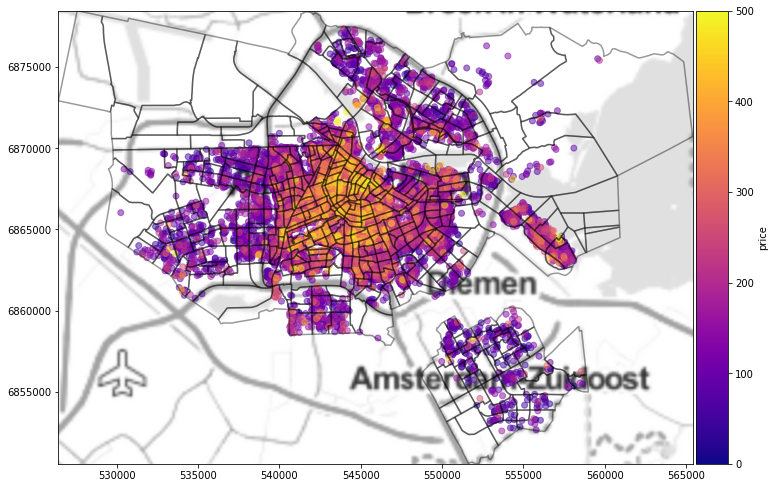

In [113]:
f = plt.figure(figsize=(12,12))
ax = plt.gca()
buurt.boundary.plot(color='k', ax=ax, alpha=.4)
ax.imshow(basemap, extent=bounds, interpolation='gaussian', alpha= .8)
ax.axis(buurt.total_bounds[np.asarray([0,2,1,3])])
df2.sort_values('price').plot('price', ax=ax, marker='o', cmap='plasma', alpha=.5)

sm = plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=vmin, vmax=vmax))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
# fake up the array of the scalar mappable. 
sm._A = []
plt.colorbar(sm, cax, label='price')

In [96]:
df.head(1)

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,sd_code,sd_name,bc_id,bc_name,b_id,b_name
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,Private room,69.0,3,233,2018-06-24,2.06,1,116,POINT (124637.2554813915 486523.2381693435),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt


In [99]:
df[df.b_name == 'Holendrecht West']

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,sd_code,sd_name,bc_id,bc_name,b_id,b_name
19255,2934713,Temporary furnitured room in Ams!,14983658,Eva,Gaasperdam - Driemond,Private room,270.0,1,0,NaT,NaN,1,0,POINT (125972.1679188422 479231.3665990605),T,Zuidoost,3630012052061,Holendrecht/Reigersbos,03630000000732,Holendrecht West


In [97]:
district_price = df.groupby(['b_name']).price.median().to_frame()
district_price.sort_values(by='price', ascending=False)[:5]

,price
b_name,
Rieteiland Oost,295.0
Hiltonbuurt,275.0
Holendrecht West,270.0
Minervabuurt Noord,262.5
NDSM terrein,250.0


In [100]:
buurt = buurt.merge(district_price,
                    left_on='b_name', 
                    right_index=True, how='left')
buurt = buurt.rename(columns=dict(price='median_price'))

The Quantiles scheme is one map classification method that GeoPanda includes, which are in turn based on PySAL

In [ ]:
df.plot()

array([ 526403.03595246,  565409.75197688, 6850580.04617034,
       6878445.769546  ])

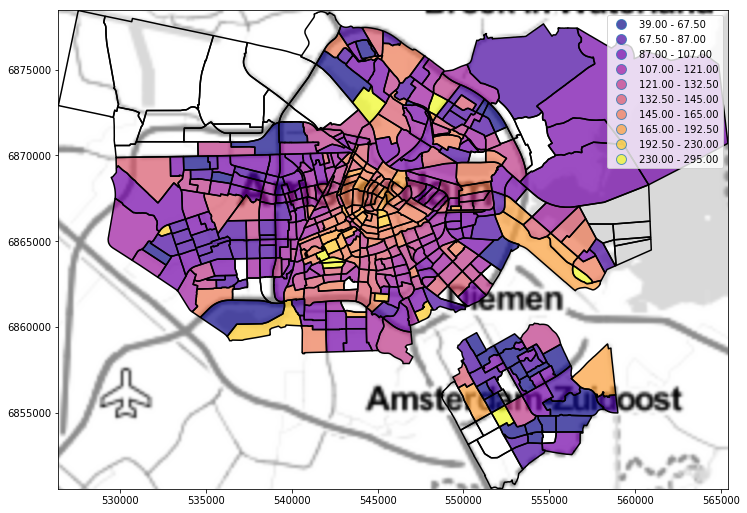

In [108]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
buurt.boundary.plot(color='black', ax=ax)
buurt.dropna().plot(column= 'median_price', scheme='Fisher_Jenks', k=10, legend=True,
                    cmap='plasma', alpha=.7, ax=ax)
#basemap of the area
ax.imshow(basemap, extent=bounds, interpolation='gaussian')
ax.axis(buurt.total_bounds[np.asarray([0,2,1,3])])

In [127]:
import seaborn as sns

/home/diederik/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [129]:
df

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,sd_code,sd_name,bc_id,bc_name,b_id,b_name
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,Private room,69.0,3,233,2018-06-24,2.06,1,116,POINT (124637.2554813915 486523.2381693435),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt
1,25488,**Lovely 3 bedrooms Apartment *,106225,Jeff,Oostelijk Havengebied - Indische Buurt,Entire home/apt,174.0,3,153,2018-06-27,1.55,2,5,POINT (124783.399754066 486439.4765869856),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt
2,862597,Clean cosy apartment,4521818,Nils,Oostelijk Havengebied - Indische Buurt,Entire home/apt,150.0,3,129,2018-06-17,2.06,1,137,POINT (124573.2483287627 486362.1700986144),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt
3,1605387,Cozy 2 room grndfloor apartment - 45 sq metre,1125467,Rudolf,Oostelijk Havengebied - Indische Buurt,Entire home/apt,85.0,4,17,2018-03-09,0.29,1,0,POINT (124571.123777138 486427.5340930934),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt
4,1835186,Well-equipped Cozy Room • Guest Bathroom,9595076,Andrea,Oostelijk Havengebied - Indische Buurt,Private room,54.0,3,188,2018-06-20,3.56,1,50,POINT (124552.0660291437 486253.1891093268),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt
5,1938510,Stay in Amsterdam like a local,3576012,Sheryl & Lukasz,Oostelijk Havengebied - Indische Buurt,Entire home/apt,330.0,2,77,2018-06-21,1.50,1,186,POINT (124630.3610275431 486188.0740029688),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt
6,2275974,Cozy spacious 70m2 fully furnished,195580,Jakob,Oostelijk Havengebied - Indische Buurt,Entire home/apt,70.0,2,7,2015-10-31,0.13,1,0,POINT (124923.9209226826 486174.3882348963),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt
7,3244143,Nice apartment in Oost with garden!,9121320,Carry,Oostelijk Havengebied - Indische Buurt,Entire home/apt,80.0,7,43,2018-05-28,0.87,1,1,POINT (124651.5294182766 486494.1250569469),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt
8,3419443,Apartment in trendy neighbourhood,17238160,Frits,Oostelijk Havengebied - Indische Buurt,Entire home/apt,160.0,3,3,2016-05-16,0.08,1,0,POINT (124714.3037523202 486476.6190958135),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt
9,3673223,Private room in vibrant area,18646888,Yara,Oostelijk Havengebied - Indische Buurt,Entire home/apt,100.0,2,11,2017-11-01,0.23,1,0,POINT (124632.2499414848 486185.8271039412),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt


In [138]:
sd

,sd_code,geometry,sd_id,sd_name
0,B,"POLYGON ((115438.2551681 489780.5773693, 11543...",03630000000020,Westpoort
1,M,"POLYGON ((123334.2436606 486309.3116985, 12340...",03630011872039,Oost
2,N,"POLYGON ((126867.5316472 487456.3432995, 12661...",03630000000019,Noord
3,A,"POLYGON ((120535.889057 486273.4893039, 120528...",03630000000018,Centrum
4,E,"POLYGON ((118423.4169138 485693.1108398, 11840...",03630011872036,West
5,F,"POLYGON ((118044.319122 485048.0111144, 118095...",03630011872037,Nieuw-West
6,K,"POLYGON ((118669.4043669 485703.1518227, 11872...",03630011872038,Zuid
7,T,"POLYGON ((129103.242 479278.077, 129090.573 47...",03630000000016,Zuidoost


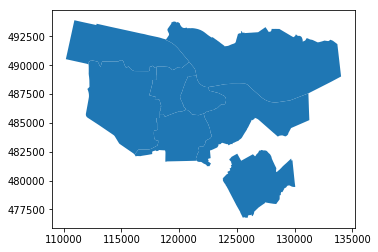

In [142]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
gp.plotting.plot_polygon_collection(ax, sd['geometry'])

In [133]:
for poly in sd['geometry']:
        gp.plotting.plot_polygon_collection(ax, poly, facecolor='grey', linewidth=0.)

TypeError: object of type 'Polygon' has no len()

In [128]:
def map_subset(vals, db, color=None, norm=True):
    '''
    Internal function to pass to `FaceGrid` to build a single map
    ...
    
    Arguments
    ---------
    vals     : Series
               Values of the subplot to be mapped
    db       : GeoDataFrame
               Table with geometries
    color    : None
    '''
    ax = plt.gca()
    for poly in sd['geometry']:
        gpd.plotting.plot_multipolygon(ax, poly, facecolor='grey', linewidth=0.)
    vari = vals.name
    if norm:
        db.reindex(vals.index).plot(column=vari, ax=ax, cmap='Blues', linewidth=0., \
                               vmin=db[vari].min(), vmax=db[vari].max())
    else:
        db.reindex(vals.index).plot(column=vari, ax=ax, cmap='Blues', linewidth=0.)
    ax.set_axis_off()
    plt.axis('equal')

In [130]:
%%time
g = sns.FacetGrid(both, row="room_type", col="Status_Majority", \
                  margin_titles=True, size=5)
g.map(map_subset, "imd_score", db=both)
plt.tight_layout()
plt.show()

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,sd_code,sd_name,bc_id,bc_name,b_id,b_name
0,2818,Quiet Garden View Room & Super Fast WiFi,3159,Daniel,Oostelijk Havengebied - Indische Buurt,Private room,69.0,3,233,2018-06-24,2.06,1,116,POINT (124637.2554813915 486523.2381693435),M,Oost,3630012052077,Indische Buurt Oost,03630000000577,Noordoostkwadrant Indische buurt


In [99]:
df[df.b_name == 'Holendrecht West']

,id,name,host_id,host_name,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,sd_code,sd_name,bc_id,bc_name,b_id,b_name
19255,2934713,Temporary furnitured room in Ams!,14983658,Eva,Gaasperdam - Driemond,Private room,270.0,1,0,NaT,NaN,1,0,POINT (125972.1679188422 479231.3665990605),T,Zuidoost,3630012052061,Holendrecht/Reigersbos,03630000000732,Holendrecht West


In [ ]:
%%time
g = sns.FacetGrid(df row="Gender_Majority", col="Status_Majority", \
                  margin_titles=True, size=5)
g.map(map_subset, "imd_score", db=both)
plt.tight_layout()
plt.show()

In [ ]:
### adjecency graphs represent how polygons relate to each other

In [121]:
import libpysal.api as lp


In [122]:
Qneighbs = lp.Queen.from_dataframe(buurt) # adjecency graphs

(<matplotlib.figure.Figure at 0x7fa7bd9fa2b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa7bd9fa9e8>)

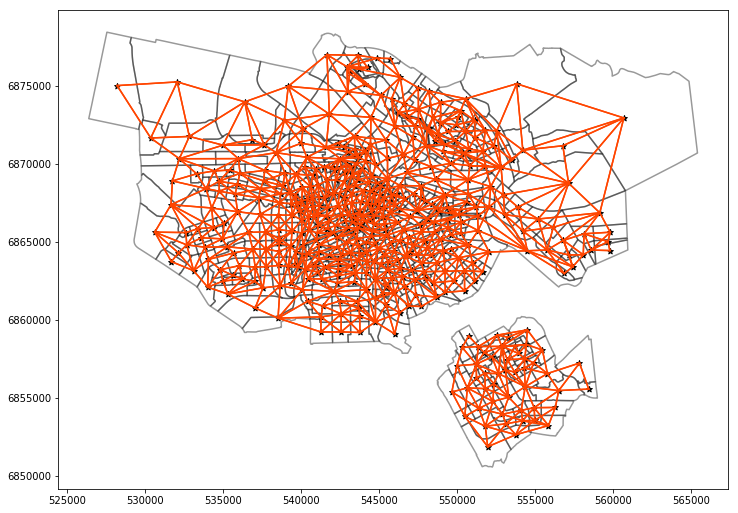

In [125]:
fig, ax = plt.subplots(figsize=[12,10])
buurt.boundary.plot(color='k', ax=ax, alpha=.4)
Qneighbs.plot(buurt, edge_kws=dict(linewidth=1.5, color='orangered'), 
              node_kws=dict(marker='*'), ax=ax)

This visualisation depicts the spatial weights network, a network of connections of the centroid of each polygon to the centroid of its neighbour. As we can see, there are many polygons in the south and west of this map, that are not connected to its neighbors.

In [126]:
Qneighbs.islands

[]

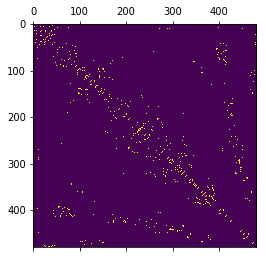

In [144]:
spqneighbs = Qneighbs.sparse
spqneighbs.eliminate_zeros()
plt.matshow(spqneighbs.toarray())

In [145]:
Qneighbs.pct_nonzero

1.300132693064086

In [114]:
import mapclassify.api as mc

In [115]:
y = df['price']
ea5 = mc.Equal_Interval(y, k=10)

In [116]:
#Equal intervals splits the data range into  kk  equal-width bins:
ea5

               Equal Interval               
 
 Lower            Upper                Count
          x[i] <=  57.100                759
 57.100 < x[i] <= 106.200               6299
106.200 < x[i] <= 155.300               6605
155.300 < x[i] <= 204.400               3082
204.400 < x[i] <= 253.500               1300
253.500 < x[i] <= 302.600                657
302.600 < x[i] <= 351.700                272
351.700 < x[i] <= 400.800                199
400.800 < x[i] <= 449.900                 43
449.900 < x[i] <= 499.000                100

In [117]:
q5 = mc.Quantiles(y, k=5)
ei5 = mc.Equal_Interval(y, k=5)
mb5 = mc.Maximum_Breaks(y, k=5)
fj5 = mc.Fisher_Jenks(y, k=5)
fits = [c.adcm for c in [q5, ei5, mb5, fj5]]
fits

/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[317137.0, 376386.0, 920217.0, 295422.0]

Fisher Jenks is the optimal classifer.

In [118]:
bp = mc.Box_Plot(y)
bp

/home/diederik/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


                  Box Plot                  
 
 Lower            Upper                Count
          x[i] <= -17.500                  0
-17.500 < x[i] <=  95.000               5130
 95.000 < x[i] <= 125.000               4961
125.000 < x[i] <= 170.000               4450
170.000 < x[i] <= 282.500               3795
282.500 < x[i] <= 499.000                980

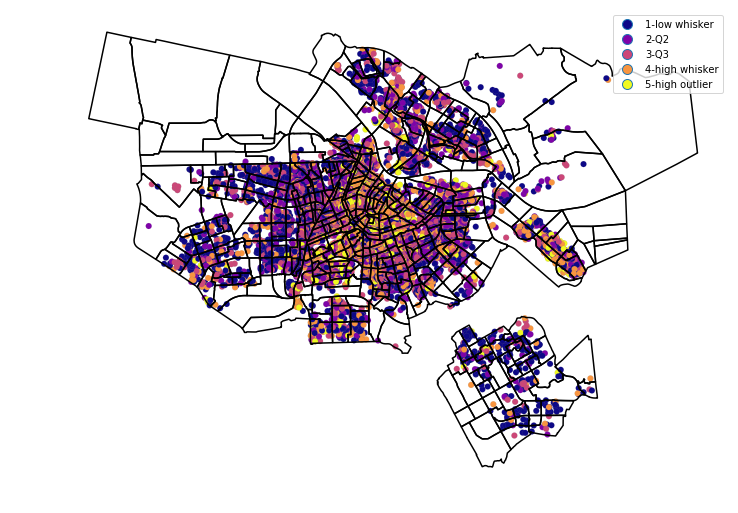

In [120]:
labels = ['0-low outlier', '1-low whisker',
          '2-Q2', '3-Q3', '4-high whisker', '5-high outlier']
bpl = [ labels[b] for b in bp.yb ]

fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
buurt.boundary.plot(color='black', ax=ax)

(df2.assign(cl=bpl).plot(column='cl', categorical=True, 
                        k=4, cmap='plasma', linewidth=0.1, ax=ax,
                        edgecolor='grey', legend=True))
ax.set_axis_off()